In [1]:
import json
import os

annotation_path = '/data3/chengyeh/COCO-Amodal/annotations/COCO_amodal_train2014.json'
with open(annotation_path, 'r') as f:
    coco_amodal = json.load(f)

print(coco_amodal.keys())

dict_keys(['images', 'annotations'])


In [2]:
__author__ = 'yzhu'
__version__ = '0.1'
import pycocotools._mask as mask
import json
import datetime
import time
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import numpy as np
from skimage.draw import polygon
import urllib
import copy
import itertools
import os
from pycocotools.coco import COCO


class Amodal(COCO):
    def __init__(self, annotation_file=None, verbose=True):
        """
        Constructor of Microsoft COCO helper class for reading and visualizing annotations.
        :param annotation_file (str): location of annotation file
        :param image_folder (str): location to the folder that hosts images.
        :return:
        """
        COCO.__init__(self, annotation_file)
        self.verbose = verbose

    def createIndex(self):
        # create index
        print('creating index...')
        anns = {}
        imgToAnns = {}
        imgs = {}
        regions = []
        if 'annotations' in self.dataset:
            imgToAnns = {ann['image_id']: [] for ann in self.dataset['annotations']}
            anns =      {ann['id']:       [] for ann in self.dataset['annotations']}
            for ann in self.dataset['annotations']:
                imgToAnns[ann['image_id']] += [ann]
                anns[ann['id']] = ann
                for region in ann['regions']:
                    region['image_id'] = ann['image_id']
                    regions.append(region)

        if 'images' in self.dataset:
            imgs      = {im['id']: {} for im in self.dataset['images']}
            for img in self.dataset['images']:
                imgs[img['id']] = img

        print('index created!')

        # create class members
        self.anns = anns
        self.imgToAnns = imgToAnns
        self.imgs = imgs
        self.regions = regions

    def getAmodalAnnIds(self, imgIds=[]):
        """
        Get amodal ann id that satisfy given fiter conditions.
        :param imgIds (int array): get anns for given imgs
        :return: ids (int array) : integer array of ann ids
        """
        imgIds = imgIds if type(imgIds) == list else [imgIds]

        if len(imgIds) == 0:
            anns = self.dataset['annotations']
        else:
            lists = [self.imgToAnns[imgId] for imgId in imgIds if imgId in self.imgToAnns]
            anns = list(itertools.chain.from_iterable(lists))
        ids = [ann['id'] for ann in anns]

        return ids

    def getImgIds(self, imgIds=[], catIds=[]):
        '''
        Get img ids that satisfy given filter conditions.
        :param imgIds (int array) : get imgs for given ids
        :param catIds (int array) : get imgs with all given cats
        :return: ids (int array)  : integer array of img ids
        '''
        imgIds = imgIds if type(imgIds) == list else [imgIds]
        catIds = catIds if type(catIds) == list else [catIds]

        if len(imgIds) == len(catIds) == 0:
            ids = self.imgs.keys()
        else:
            ids = set(imgIds)
            for i, catId in enumerate(catIds):
                if i == 0 and len(ids) == 0:
                    ids = set(self.catToImgs[catId])
                else:
                    ids &= set(self.catToImgs[catId])
        return list(ids)

    def showAmodalAnns(self, anns):
        """
        Display a set of amodal Ann object.
        :param anns: a dict object
        return: None
        """
        if type(anns) == list:
            print("anns cannot be a list! Should be a dict.")
            return 0
        ax = plt.gca()
        polygons = []
        lines = []
        color = []
        for ann in reversed(anns['regions']):
            c = np.random.random((1, 3)).tolist()[0]
            if type(ann['segmentation']) == list:
                # polygon
                seg = ann['segmentation']
                poly = np.array(seg).reshape((len(seg) // 2, 2))
                polygons.append(Polygon(poly, True, alpha=0.2))
                color.append(c)
            else:
                print("todo")
                raise NotImplementedError

        p = PatchCollection(polygons, facecolors=color, edgecolors=(0,0,0,1), linewidths=3, alpha=0.8)
        ax.add_collection(p)

    def showEdgeMap(self, anns):
        """
        Show edge map for an annontation
        :param anns: a dict object
        return: None
        """
        if type(anns) == list:
            print("anns cannot be a list! Should be a dict")
            return 0
        ax = plt.gca()
        polygons = []
        lines = []
        color = []
        for ann in reversed(anns['regions']):
            c = np.zeros([1, 3]).tolist()[0]
            if type(ann['segmentation']) == list:
                # polygon
                seg = ann['segmentation']
                poly = np.array(seg).reshape((len(seg) // 2, 2))
                polygons.append(Polygon(poly, True, alpha=0.2))
                color.append(c)
            else:
                print("todo")
                raise NotImplementedError

        p = PatchCollection(polygons, facecolors=color, edgecolors=(1,1,1,1), linewidths=1, alpha=1)
        ax.add_collection(p)

    def showMask(self, M, ax, c = [0, 1, 0]):
        m = mask.decode([M])
        img = np.ones( (m.shape[0], m.shape[1], 3) )
        
        # get boundary quickly
        B = np.zeros( (m.shape[0], m.shape[1]) )
        for aa in range(m.shape[0]-1):
            for bb in range(m.shape[1]-1):
                #kk = aa*m.shape[1]+bb
                if m[aa,bb] != m[aa,bb+1]:
                    B[aa,bb], B[aa,bb+1] = 1,1
                if m[aa,bb] != m[aa+1,bb]:
                    B[aa,bb], B[aa+1,bb] = 1,1
                if m[aa,bb] != m[aa+1,bb+1]:
                    B[aa,bb], B[aa+1,bb+1] = 1,1
                    
        for i in range(3):
            img[:, :, i] = c[i]
            ax.imshow(np.dstack( (img, B*1) ))
            ax.imshow(np.dstack( (img, m*0.3) ))
 
    def showAmodalInstance(self, anns, k=-1):
        """
        Display k-th instance only: print segmentation first, then print invisible_mask
        anns: a single annotation
        k: the depth order of anns, 1-index. If k = -1, just visulize input
        """
        ax = plt.gca()
        c = np.random.random((1,3)).tolist()[0]
        c = [0.0, 1.0, 0.0] # green
        
        if k < 0:
           self.showMask(anns['segmentation'], ax)
           return

        if type(anns) == list:
            print("ann cannot be a list! Should be a dict")
            return 0
        ann = anns['regions'][k-1]
        polygons = []
        color = []
        # draw whole mask
        if type(ann['segmentation']) == list:
            # polygon
            seg = ann['segmentation']
            poly = np.array(seg).reshape((len(seg) // 2, 2))
            polygons.append(Polygon(poly, True, alpha=0.2))
            color.append(c)
            p = PatchCollection(polygons, facecolors=color, edgecolors=(1,1,1,1), linewidths=3, alpha=0.2)
            ax.add_collection(p)
        else:
            self.showMask(ann['segmentation'], ax)
        
        # draw invisible_mask
        if 'invisible_mask' in ann:
            self.showMask(ann['invisible_mask'], ax, [1, 0, 0])

    def showModalInstance(self, anns, k):
        """
        Display k-th instance: print its visible mask
        anns: a single annotation
        k: the depth order of anns, 1-index
        """
        if type(anns) == list:
            print("ann cannot be a list! Should be a dict")
            return 0
        ax = plt.gca()
        c = np.random.random((1,3)).tolist()[0]
        c = [0.0, 1.0, 0.0] # green
        ann = anns['regions'][k-1]
        polygons = []
        color = []
        # draw whole mask
        if 'visible_mask' in ann:
            mm = mask.decode([ann['visible_mask']])
            img = np.ones( (mm.shape[0], mm.shape[1], 3) )
            color_mask = c
            for i in range(3):
                img[:, :, i] = color_mask[i]
            ax.imshow(np.dstack( (img, mm*0.6) ))
        else:
            if type(ann['segmentation']) == list:
                # polygon
                seg = ann['segmentation']
                poly = np.array(seg).reshape((len(seg) // 2, 2))
                polygons.append(Polygon(poly, True, alpha=0.2))
                color.append(c)
            else:
                #mask
                mm = mask.decode([ann['segmentation']])
                img = np.ones( (mm.shape[0], mm.shape[1], 3) )
                color_mask = c
                for i in range(3):
                    img[:, :, i] = color_mask[i]
                ax.imshow(np.dstack( (img, mm*0.6) ))
            
            p = PatchCollection(polygons, facecolors=color, edgecolors=(0,0,0,1), linewidths=3, alpha=0.4)
            ax.add_collection(p)

    def loadRes(self, resFile):
        """
        Load result file and return a result api object.
        :param   resFile (str)     : file name of result file
        :return: res (obj)         : result api object
        """
        res = Amodal()
        res.dataset['images'] = [img for img in self.dataset['images']]
        if self.verbose:
            print('Loading and preparing results...')
        tic = time.time()
        anns    = json.load(open(resFile))
        assert type(anns) == list, 'results in not an array of objects'
        annsImgIds = [ann['image_id'] for ann in anns]
        
        assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
               'Results do not correspond to current coco set'
        if self.verbose:
            print('DONE (t=%0.2fs)'%(time.time()- tic))
        res.dataset['annotations'] = anns
        res.createIndex()
        return res

amodal = Amodal(annotation_path)

loading annotations into memory...
Done (t=0.90s)
creating index...
index created!


In [3]:
from tqdm import tqdm
num_objects = 0
images = set()
for ann in tqdm(coco_amodal['annotations']):
    num_objects += len(ann['regions'])
    images.add(ann['image_id'])

print(coco_amodal['annotations'][0])
print(len(images))
print(num_objects)

100%|██████████| 2500/2500 [00:00<00:00, 790125.84it/s]

{'author': 'ash2', 'url': 'https://s3-us-west-1.amazonaws.com/coco-ann/coco-train/COCO_train2014_000000000321.jpg', 'regions': [{'segmentation': [118.81035390563136, 406.0363914067311, 128.12455234161916, 404.76627343818734, 134.05176952815685, 402.2260375010997, 137.43875077760697, 400.1091742201935, 135.74526015288188, 408.1532546876374, 137.86212343378818, 414.92721718653763, 143.7893406203259, 417.46745312362526, 149.29318515068235, 419.16094374835035, 153.52691171249498, 422.1245523416191, 158.18401093048888, 422.5479249978004, 162.4177374923015, 420.4310617168941, 167.49820936647666, 419.16094374835035, 169.615072647383, 421.70117968543786, 171.30856327210805, 422.5479249978004, 174.69554452155816, 420.0076890607128, 178.9292710833708, 413.23372656181266, 192.4771960811712, 413.23372656181266, 208.5653570160592, 410.2701179685437, 221.26653670149716, 407.3065093752749, 230.58073513748494, 403.9195281258248, 232.6975984183913, 399.68580156401214, 240.318306229654, 390.794975784205

/home/chengyeh/.conda/envs/TAO-Amodal-gtr/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_4033640/2174549548.py:117: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  polygons.append(Polygon(poly, True, alpha=0.2))


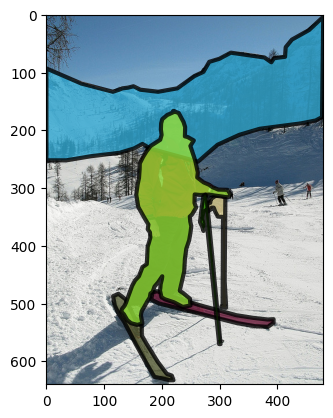

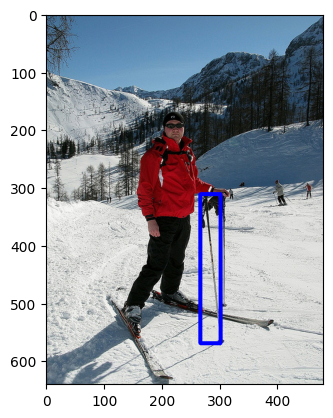

In [4]:
import random
import skimage.io as io
# random select one image
dataDir='/data3/chengyeh/COCO-Amodal/train2014'
random.seed(0)
imgId = random.choice(amodal.dataset['images'])['id']
#imgId = 327590 # cached image demo for coco
annIds = amodal.getAmodalAnnIds(imgIds=imgId)
anns = amodal.loadAnns(annIds)
ann = random.choice(anns)
from detectron2.structures.masks import polygons_to_bitmask
img = amodal.loadImgs(imgId)[0]
I = io.imread(os.path.join(dataDir, img['file_name']))
plt.figure()
plt.imshow(I)
amodal.showAmodalAnns(ann) 

seg = ann['regions'][-2]['segmentation']

bit_mask = polygons_to_bitmask([ann['regions'][0]['segmentation'] for i in range(len(ann['regions']))], height=I.shape[0], width=I.shape[1])

def bounding_box(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return cmin, rmin, cmax - cmin, rmax - rmin # x1, y1, x2, y2 

bbox = bounding_box(bit_mask)
import cv2 


I = cv2.rectangle(I, bbox[:2], [bbox[2] + bbox[0], bbox[3] + bbox[1]], color=(0, 0, 255), thickness=5)
plt.figure()
plt.imshow(I)

In [5]:
from tqdm import tqdm
print(len(amodal.dataset['images']))
converted_coco_amodal = {
    'images': [],
    'annotations': []
}

for image in tqdm(amodal.dataset['images']):
    image['not_exhaustive_category_ids'] = []
    image['neg_category_ids'] = []
    converted_coco_amodal['images'].append(image)



2500


100%|██████████| 2500/2500 [00:00<00:00, 1458989.84it/s]


2500it [01:47, 23.29it/s]


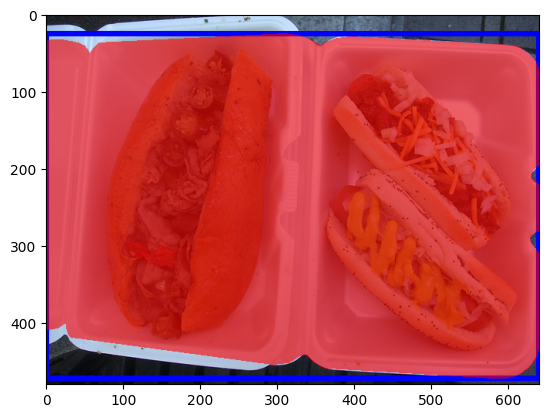

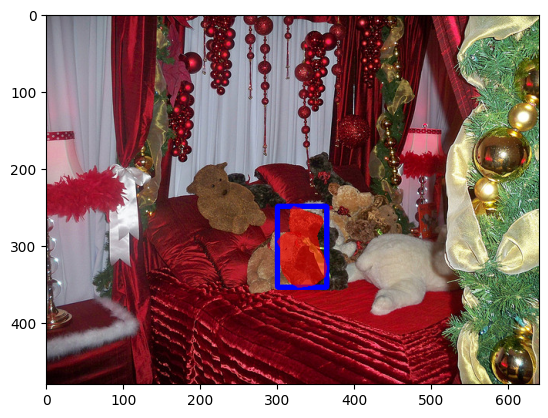

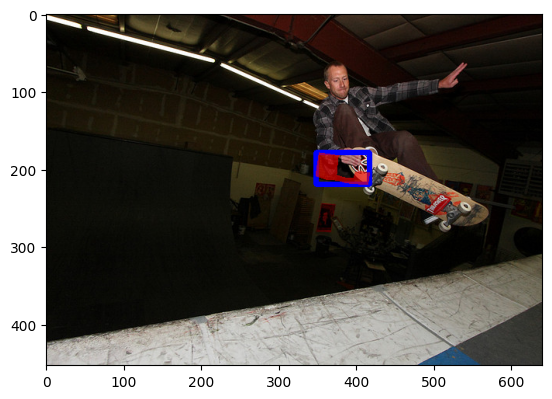

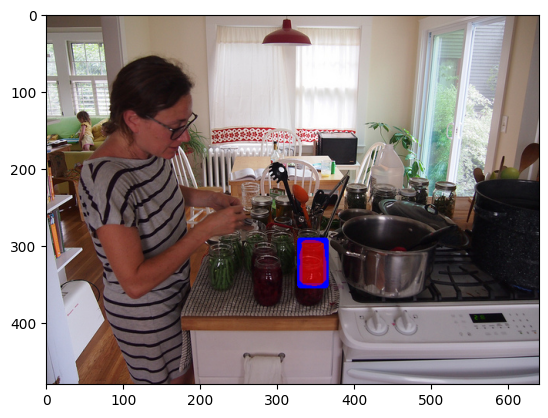

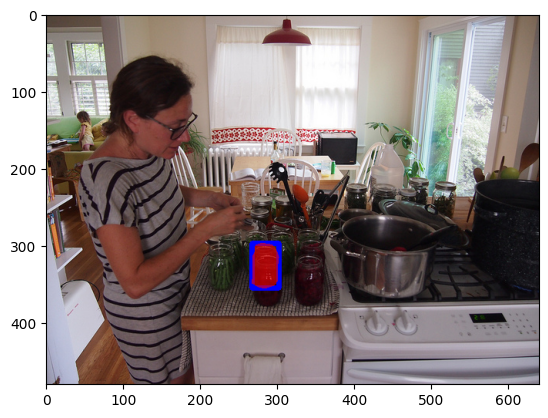

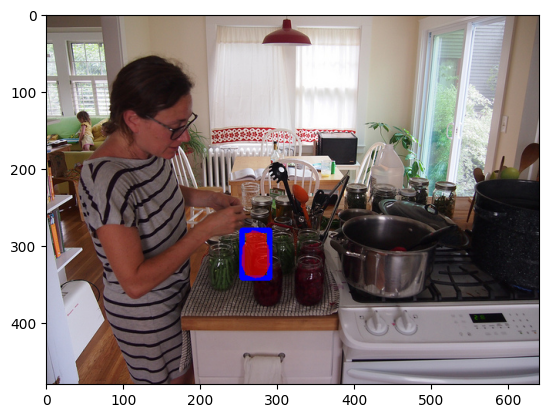

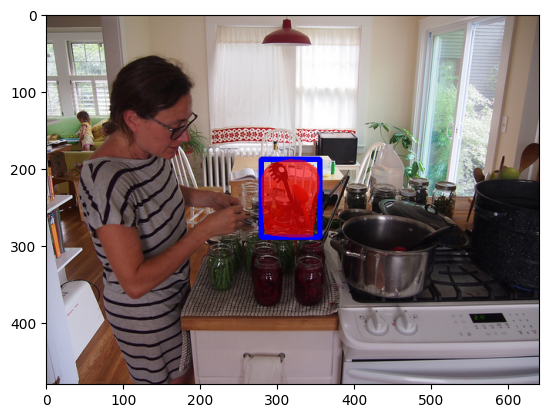

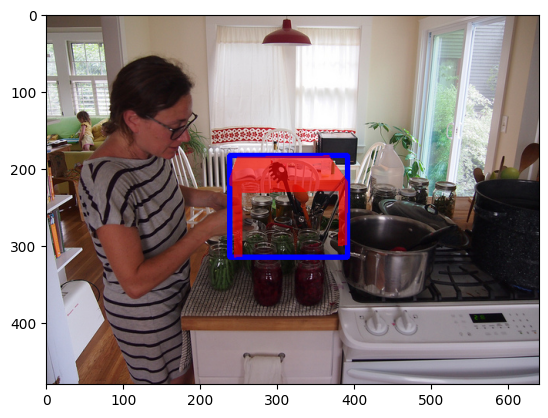

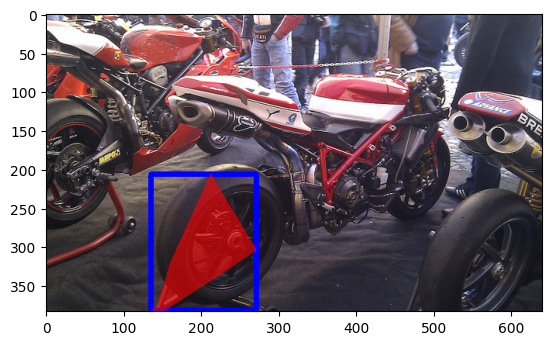

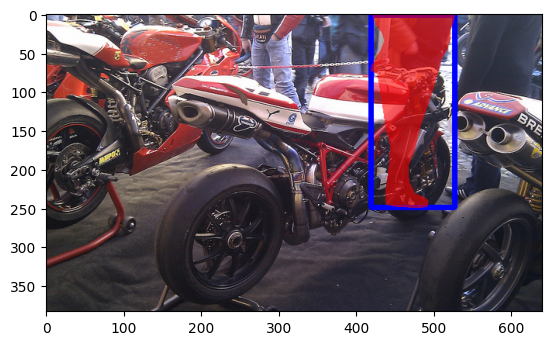

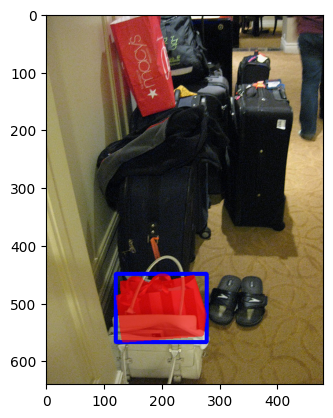

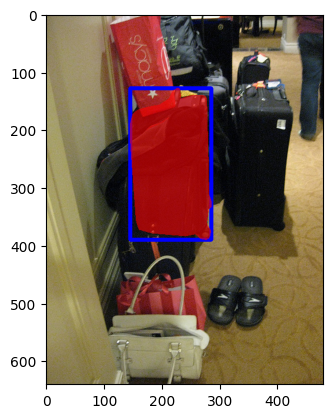

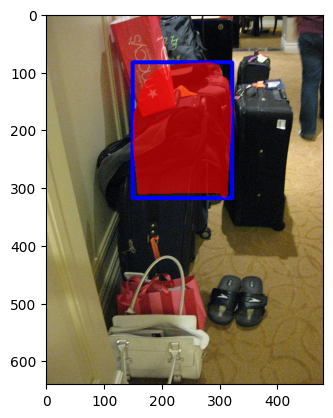

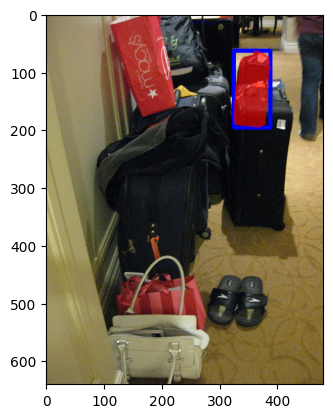

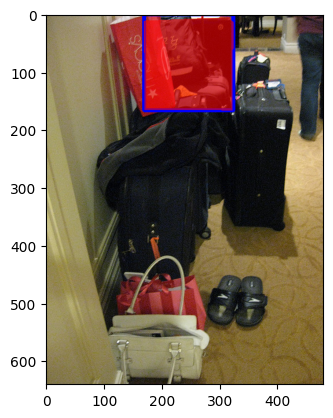

In [6]:
num_visualized = 0
ann_id = 0
converted_coco_amodal['annotations'] = []
for i, ann in tqdm(enumerate(amodal.dataset['annotations'][:])):
    for segmentation_dict in ann['regions'][:]:
        if segmentation_dict['isStuff']:
            continue

        seg = segmentation_dict['segmentation']
        
        img = amodal.loadImgs(ann['image_id'])[0]
        img = io.imread(os.path.join(dataDir, img['file_name']))
        bit_mask = polygons_to_bitmask([seg], height=img.shape[0], width=img.shape[1])


        bbox = list(bounding_box(bit_mask))
        
        if segmentation_dict['occlude_rate'] > 0.5 and num_visualized < 15:
            num_visualized += 1
            img = cv2.rectangle(img, bbox[:2], [bbox[2] + bbox[0], bbox[3] + bbox[1]], color=(0, 0, 255), thickness=5)
            red_mask = np.zeros_like(img)
            red_mask[:, :, 0] = 255
            red_mask[:, :, 1] = 0
            red_mask[:, :, 2] = 0

            img[bit_mask == 1] = cv2.addWeighted(img[bit_mask == 1], 0.4, red_mask[bit_mask == 1], 0.6, 0)
            # img[bit_mask == 1] = img[bit_mask == 1] * red_mask[bit_mask == 1] * 0.7 + img[bit_mask == 1] * 0.3
            plt.figure()
            plt.imshow(img)

        new_ann = {
            'id': int(ann_id),
            'image_id': int(ann['image_id']),
            'category_id': int(80),  # Fake Category Id
            'area': float(bbox[2] * bbox[3]),
            'bbox': list(map(float, bbox))
        }
        ann_id += 1
        converted_coco_amodal['annotations'].append(new_ann)


In [11]:
from detectron2.data.datasets.lvis_v1_categories import LVIS_CATEGORIES
lvis_categories = LVIS_CATEGORIES
converted_coco_amodal['categories'] = lvis_categories  # Create Fake Category

saved_path = annotation_path.replace('.json', '_GTR_amodal_expander_training.json')
print('Length of images: {}'.format(len(converted_coco_amodal['images'])))
print('Length of annotations: {}'.format(len(converted_coco_amodal['annotations'])))
print('# categories: {}'.format(len(converted_coco_amodal['categories'])))
print('Save Converted COCO Amodal to {}...'.format(saved_path))


with open(saved_path, 'w') as f:
    
    json.dump(converted_coco_amodal, f)

Length of images: 2500
Length of annotations: 15139
# categories: 1203
Save Converted COCO Amodal to /data3/chengyeh/COCO-Amodal/annotations/COCO_amodal_train2014_GTR_amodal_expander_training.json...
{'license': 1, 'file_name': 'COCO_train2014_000000000321.jpg', 'coco_url': 'http://mscoco.org/images/321', 'height': 480, 'width': 640, 'date_captured': '2013-11-20 12:36:25', 'flickr_url': 'http://farm5.staticflickr.com/4096/4750559893_49fb0baf7f_z.jpg', 'id': 321, 'not_exhaustive_category_ids': [], 'neg_category_ids': []}
